In [1]:
!pip install gym
!pip install pygame
!pip install tf_agents==0.15.0
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gym
import numpy as np
import pygame
import time
import random
from gym import spaces
from gym.envs.registration import register
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

# player piece colors [player1, player2]
colors = ['#FF0000', '#0000FF']

# paths for each tile 1-35
node_combinations = [ 
    [(0,3), (1,5), (2,6), (4,7)], [(0,4), (1,5), (2,6), (3,7)], [(0,3), (1,6), (2,5), (4,7)], [(0,6), (1,5), (2,4), (3,7)],
    [(0,1), (2,3), (4,5), (6,7)], [(0,4), (1,5), (2,3), (6,7)], [(0,6), (1,5), (2,3), (4,7)], [(0,5), (1,4), (2,7), (3,6)],
    [(0,5), (1,4), (2,6), (3,7)], [(0,3), (1,4), (2,5), (6,7)], [(0,6), (1,4), (2,5), (3,7)], [(0,5), (1,4), (2,3), (6,7)],
    [(0,2), (1,3), (4,6), (5,7)], [(0,2), (1,3), (4,5), (6,7)], [(0,5), (1,3), (2,7), (4,6)], [(0,6), (1,3), (2,7), (4,5)],
    [(0,4), (1,3), (2,6), (5,7)], [(0,5), (1,3), (2,6), (4,7)], [(0,4), (1,3), (2,5), (6,7)], [(0,6), (1,3), (2,5), (4,7)],
    [(0,5), (1,3), (2,4), (6,7)], [(0,6), (1,3), (2,4), (5,7)], [(0,3), (1,2), (4,7), (5,6)], [(0,3), (1,2), (4,6), (5,7)],
    [(0,3), (1,2), (4,5), (6,7)], [(0,4), (1,2), (3,7), (5,6)], [(0,5), (1,2), (3,7), (4,6)], [(0,6), (1,2), (3,7), (4,5)],
    [(0,4), (1,2), (3,6), (5,7)], [(0,5), (1,2), (3,6), (4,7)], [(0,4), (1,2), (3,5), (6,7)], [(0,6), (1,2), (3,5), (4,7)],
    [(0,5), (1,2), (3,4), (6,7)], [(0,6), (1,2), (3,4), (5,7)], [(0,7), (1,2), (3,4), (5,6)]
]


In [3]:
class Tile():
    def __init__(self, tile_num, tile_connections):
        self.tile_num = tile_num
        self.image = pygame.image.load("TsuroImages/" + str(tile_num) + ".png")
        self.image = pygame.transform.scale(self.image, (100, 100))
        self.tile_connections = tile_connections
        self.rotation = 1
    
    def move(self, current_node):
        next_node = 0
        next_player_tile = 0
        for connection in self.tile_connections:
            if current_node in connection:
                n1, n2 = connection
                if n1 == current_node:
                    next_node, next_player_tile, next_x, next_y = self.new_tile_node(n2)
                else:
                    next_node, next_player_tile, next_x, next_y = self.new_tile_node(n1)
                return next_node, next_player_tile, next_x, next_y
        raise Exception("Issue in moving players")
    
    # update number of times rotation should be applied to connections and image
    def rotate_tile(self, rotate):
        self.image = pygame.transform.rotate(self.image, rotate * -90)
        self.tile_connections = [tuple((element + (2 * rotate)) % 8 for element in couple ) for couple in self.tile_connections]
        self.rotation = 1 if (self.rotation + 1 % 4 == 0) else self.rotation + 1
        
    def get_rotation(self):
        return self.rotation
    
    def new_tile_node(self, current_node):
        next_node = 0
        next_x = 0
        next_y = 0
        next_player_tile = 0
        match current_node:
            case 0:
                next_node = 3
                next_player_tile = -1
                next_x = -1
            case 1:
                next_node = 6
                next_player_tile = -6
                next_y = -1
            case 2:
                next_node = 5
                next_player_tile = -6
                next_y = -1
            case 3:
                next_node = 0
                next_player_tile = 1
                next_x = 1
            case 4:
                next_node = 7
                next_player_tile = 1
                next_x = 1
            case 5:
                next_node = 2
                next_player_tile = 6
                next_y = 1
            case 6:
                next_node = 1
                next_player_tile = 6
                next_y = 1
            case 7:
                next_node = 4
                next_player_tile = -1
                next_x = -1
            case _:
                raise Exception("Issue in tile board")
                
        return next_node, next_player_tile, next_x, next_y
    

In [4]:
class TsuroEnv(gym.Env):
    #
    def __init__(self):
        self.screen = None
        self.current_player = 1
        self.num_tiles = 35
        self.tile_board_size = (6, 6)
        self.rotation_board_size = (6, 6)
        self.player_board_size = (36,8)
        self.num_players = 2
        self.tiles = []
        for i in range(self.num_tiles):
            self.tiles.append(Tile(i, node_combinations[i]))
            
        self.remaining_tiles = []
        for i in range(self.num_tiles):
            self.remaining_tiles.append(i)
        random.shuffle(self.remaining_tiles)

        self.remaining_players = []
        for i in range(self.num_players):
            self.remaining_players.append(i+1)
        
        self.player_tiles = []
        for i in range(self.num_players):
            player_tiles = []
            for i in range(3):
                player_tiles.append(self.remaining_tiles.pop())
            self.player_tiles.append(player_tiles)
            
        self.rotation_board = np.zeros(self.rotation_board_size, dtype = int)
        self.tile_board = np.zeros(self.tile_board_size, dtype = int)
        self.player_board = np.zeros(self.player_board_size, dtype = int)

        self.action_space = spaces.Discrete(11)
        self.observation_space = spaces.Box(low=-1, high=140, shape=(327,))
        
    def get_tile_obs(self):
        temp = self.rotation_board.flatten()
        temp1 = self.tile_board.flatten()
        for i in range(35):
            temp[i] = ((temp[i] - 1) * 35) + temp1[i]
        return temp
        
    # Resets the environment to default state
    def reset(self): 
        self.current_player = 1
        self.rotation_board = np.zeros(self.rotation_board_size, dtype = int)
        self.tile_board = np.zeros(self.tile_board_size, dtype = int)
        self.player_board = np.zeros(self.player_board_size, dtype = int)
        
        self.tiles = []
        for i in range(self.num_tiles):
            self.tiles.append(Tile(i, node_combinations[i]))
            
        self.remaining_tiles = []
        for i in range(self.num_tiles):
            self.remaining_tiles.append(i)
        random.shuffle(self.remaining_tiles)
            
        self.remaining_players = []
        for i in range(self.num_players):
            self.remaining_players.append(i+1)
            
        self.player_tiles = []
        for i in range(self.num_players):
            player_tiles = []
            for i in range(3):
                player_tiles.append(self.remaining_tiles.pop())
            self.player_tiles.append(player_tiles)
            
        #########################################
        #TODO: TESTING STUFF TO BE REMOVED LATER#
        #########################################
        for i in range(self.num_players):
            self.player_board[random.randint(0,5)][i+1] = i+1
            
        initial_obs = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))

        return initial_obs
    
    # Makes a move in the game based on inputs from player or AI
    def step(self, action = -2, move = -1):
        if move == -1:
            card, rotate = self.get_card(action)
        else:
            card = move
            rotate = 0
        
        action = self.player_tiles[self.current_player - 1][card]
        
        if action == -1:
            observation = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))
            reward = -1
            done = 0
            return observation, reward, done, {}
            
        # Removes used tile and adds new tile from deck to hand
        self.player_tiles[self.current_player-1].remove(action)
        if len(self.remaining_tiles) > 0:
            self.player_tiles[self.current_player-1].append(self.remaining_tiles.pop())
        else:
            self.player_tiles[self.current_player-1].append(-1)
        
        # Rotates tile (Only used by AI)
        self.tiles[action].rotate_tile(rotate)
        
        reward = 0
        self.place_tile(action+1)
        self.move_players()
        reward = self.reward_function()
        if self.game_is_over():
            done = 1
        else:
            done = 0
        self.current_player = self.next_player()
        observation = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))
        return observation, reward, done, {}
    
    # Decides if the game is over
    def game_is_over(self):
        if len(self.remaining_players) <= 1:
            return True
        return False
    
    # Decides the reward (Only used for AI)
    def reward_function(self):
        if not self.game_is_over():
            return 1
        if self.game_is_over() and self.remaining_players[0] == self.current_player:
            return 5
        return -1
    
    # Places tile in self.tile_board
    def place_tile(self, tile):
        tile_number, node_number = np.where(self.player_board == self.current_player)
        x, y = TsuroEnv.euclidean_division(self, tile_number)
        x = x[0]
        y = y[0]
        self.tile_board[x][y] += tile
        self.rotation_board[x][y] += self.tiles[tile-1].get_rotation()
    
    # Moves player piece in self.player_board
    def move_players(self):
        for player in self.remaining_players:
            tile_number, node_number = np.where(self.player_board == player)
            x, y = TsuroEnv.euclidean_division(self, tile_number)
            x = x[0]
            y = y[0]
            while self.tile_board[x][y] != 0:
                tile = self.tiles[(self.tile_board[x][y])-1]
                next_node, next_player_tile, next_x, next_y = tile.move(node_number)
                self.player_board[tile_number[0]][node_number[0]] = 0
                if ((tile_number[0] % 6 == 0) and ((tile_number[0] + next_player_tile) % 6 == 5)) or (tile_number[0] + next_player_tile < 0) or (tile_number[0] + next_player_tile > 35) or ((tile_number[0] % 6 == 5) and ((tile_number[0] + next_player_tile) % 6 == 0)):
                    self.remaining_players.remove(player)
                    break
                else:
                    self.player_board[tile_number[0] + next_player_tile][next_node] = player
                    x += next_x
                    y += next_y
                    tile_number, node_number = np.where(self.player_board == player)
    
    # Quotient and Remainder
    def euclidean_division(self, x, y = 6):
        return x % y, x // y
    
    # Action (card, rotation) from input
    def get_card(self, x, y = 4):
        return  x // y, x % y

    # Decide whos turn it is
    def next_player(self):
        if len(self.remaining_players) == 0:
            return -1
        if self.current_player not in self.remaining_players:
            for player in self.remaining_players:
                if player > self.current_player:
                    return player
                else:
                    return self.remaining_players[0]
        return self.remaining_players[(self.remaining_players.index(self.current_player) + 1) % len(self.remaining_players)]
        
    # Render the environment
    def render(self, mode):
        screen = pygame.display.set_mode((650, 750))
        screen.fill((255, 255, 255))

        # Draw the game board
        board = pygame.image.load("TsuroImages/board.png")
        board = pygame.transform.scale(board, (600, 600))
        screen.blit(board, (25,25))
        
        # Draw current players hand
        for i in range (len(self.player_tiles[self.current_player-1])):
            tile = self.player_tiles[self.current_player-1][i]
            screen.blit(self.tiles[tile].image, (75 + (i * 200), 635))
        
        # Draw the tiles on the board
        for x in range(self.tile_board_size[0]):
            for y in range(self.tile_board_size[1]):
                val = self.tile_board[x][y]
                if val != 0:
                    tile = self.tiles[val-1]
                    screen.blit(tile.image, (25 + x * 100, 25 + y * 100))
                    
        # Draw the players' pieces on the board
        for i in self.remaining_players:
            tile_number, node_number = np.where(self.player_board == i)
            y_add = 0
            x_add = 0
            y_mult = 0
            x_mult = 0
            
            match node_number[0]:
                case 0:
                    y_add = 35
                case 1:
                    x_add = 35
                case 2:
                    x_add = 70
                case 3:
                    x_add = 100
                    y_add = 35
                case 4:
                    x_add = 100
                    y_add = 70
                case 5:
                    x_add = 70
                    y_add = 100
                case 6:
                    x_add = 35
                    y_add = 100
                case 7:
                     y_add = 70
                case _:
                    raise Exception("Issue in drawing the player board")
                    
            if tile_number[0] != 0:
                x_mult, y_mult = TsuroEnv.euclidean_division(self, tile_number[0])
            
            pygame.draw.circle(screen, colors[i-1], (25 + x_add + (100 * x_mult), 25 + y_add + (100 * y_mult)), 5)
            
        # Draw text to show who won when game is over
        if self.game_is_over() or self.current_player == -1:
            font = pygame.font.Font('freesansbold.ttf', 32)
            text = font.render('Player ' + str(self.current_player) + ' wins', True, '#00FF00')
            textRect = text.get_rect()
            textRect.center = (650 // 2, 750 // 2)
            screen.blit(text, textRect)
            
        pygame.display.update()



In [5]:
num_iterations = 2000000

initial_collect_steps = 10000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 100
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 500
eval_interval = 5000

register(
    id='TsuroEnv',
    entry_point=TsuroEnv,
)

env_name = "TsuroEnv"

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

fc_layer_params = (200, 100)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    return tf.keras.layers.Dense(num_units, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'))

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(num_actions, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03), bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
    
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step)
    # commenting out render will make training quicker
    # environment.render("human")
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)
        
train_checkpointer = common.Checkpointer(
    ckpt_dir="CheckpointsRC/",
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=train_step_counter
)

train_checkpointer.initialize_or_restore()

In [6]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

agent.train = common.function(agent.train)

returns = []

with open("CheckpointsRC/returns.txt", "r") as txt:
    for line in txt:
        returns.append(line)
        
for i in range(len(returns)):
    returns[i] = returns[i].strip()
    returns[i] = float(returns[i])


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
# Initial Collection for new agent
'''
collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
'''

'\ncollect_data(train_env, random_policy, replay_buffer, initial_collect_steps)\nagent.train_step_counter.assign(0)\n\navg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)\nreturns = [avg_return]\n'

In [8]:
for _ in range(num_iterations):
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        train_checkpointer.save(train_step_counter)
        with open("CheckpointsRC/returns.txt", "w") as txt:
            for item in returns:
                txt.write(str(item) + "\n")


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 3030200: loss = 4.865280628204346
step = 3030400: loss = 3.527041435241699
step = 3030600: loss = 3.622375011444092
step = 3030800: loss = 3.211477518081665
step = 3031000: loss = 4.8109869956970215
step = 3031200: loss = 4.624529838562012
step = 3031400: loss = 4.654329776763916
step = 3031600: loss = 3.8694474697113037
step = 3031800: loss = 3.0411627292633057
step = 3032000: loss = 5.145514965057373
step = 3032200: loss = 3.139361619949341
step = 3032400: loss = 3.776602029800415
step = 3032600: loss = 3.423295497894287
step = 3032800: loss = 3.951993703842163
step = 3033000: loss = 5.076113224029541
step = 3033200: loss = 4.3107171058654785
step = 3033400: loss = 3.7145097255706787
step = 3033600: loss = 2.6638073921203613
step = 3033800: loss = 3.777981758117676
step = 3034000: loss = 5.235714435577393
step = 3034200: loss = 4.748231887817383
step = 3034400: loss = 3.5560457706451416
step = 3034600: loss = 3.447207450866699
step = 3034800: loss = 3.7002742290496826
step = 3

step = 3068400: loss = 5.106968402862549
step = 3068600: loss = 4.785187721252441
step = 3068800: loss = 4.169136047363281
step = 3069000: loss = 3.5141441822052
step = 3069200: loss = 4.465590953826904
step = 3069400: loss = 4.515452861785889
step = 3069600: loss = 4.071613788604736
step = 3069800: loss = 4.938687801361084
step = 3070000: loss = 4.098786354064941
step = 3070000: Average Return = 3.609999895095825
step = 3070200: loss = 5.8033905029296875
step = 3070400: loss = 4.014651298522949
step = 3070600: loss = 3.6342649459838867
step = 3070800: loss = 4.779423236846924
step = 3071000: loss = 3.2650418281555176
step = 3071200: loss = 5.0377421379089355
step = 3071400: loss = 4.021762371063232
step = 3071600: loss = 3.9562017917633057
step = 3071800: loss = 3.762035846710205
step = 3072000: loss = 3.7324774265289307
step = 3072200: loss = 4.017127513885498
step = 3072400: loss = 3.448364734649658
step = 3072600: loss = 4.280355930328369
step = 3072800: loss = 4.342242240905762
st

step = 3106400: loss = 4.460485935211182
step = 3106600: loss = 4.508816242218018
step = 3106800: loss = 4.70696496963501
step = 3107000: loss = 4.530359268188477
step = 3107200: loss = 3.4745359420776367
step = 3107400: loss = 4.219790458679199
step = 3107600: loss = 3.635805606842041
step = 3107800: loss = 4.70621395111084
step = 3108000: loss = 4.761289119720459
step = 3108200: loss = 3.722634792327881
step = 3108400: loss = 4.4541215896606445
step = 3108600: loss = 4.7540154457092285
step = 3108800: loss = 4.6353960037231445
step = 3109000: loss = 4.157247066497803
step = 3109200: loss = 4.781141757965088
step = 3109400: loss = 3.6642539501190186
step = 3109600: loss = 2.4099326133728027
step = 3109800: loss = 3.73052978515625
step = 3110000: loss = 3.653463363647461
step = 3110000: Average Return = 3.4619998931884766
step = 3110200: loss = 4.916297435760498
step = 3110400: loss = 4.492186546325684
step = 3110600: loss = 3.3280627727508545
step = 3110800: loss = 4.355429649353027
s

step = 3144400: loss = 3.3327271938323975
step = 3144600: loss = 3.690694808959961
step = 3144800: loss = 5.464752197265625
step = 3145000: loss = 5.609562873840332
step = 3145000: Average Return = 3.8580000400543213
step = 3145200: loss = 4.920924663543701
step = 3145400: loss = 3.615734100341797
step = 3145600: loss = 3.5358386039733887
step = 3145800: loss = 4.510359287261963
step = 3146000: loss = 4.389695644378662
step = 3146200: loss = 4.018623352050781
step = 3146400: loss = 4.293368339538574
step = 3146600: loss = 3.6175503730773926
step = 3146800: loss = 4.003779888153076
step = 3147000: loss = 4.672178745269775
step = 3147200: loss = 4.414737224578857
step = 3147400: loss = 3.6832470893859863
step = 3147600: loss = 4.4980974197387695
step = 3147800: loss = 3.341495990753174
step = 3148000: loss = 4.290015697479248
step = 3148200: loss = 3.9724180698394775
step = 3148400: loss = 4.241634845733643
step = 3148600: loss = 4.065810680389404
step = 3148800: loss = 3.971487760543823

step = 3182400: loss = 3.624516725540161
step = 3182600: loss = 4.579156398773193
step = 3182800: loss = 5.30664587020874
step = 3183000: loss = 3.8795886039733887
step = 3183200: loss = 4.055287837982178
step = 3183400: loss = 4.927237510681152
step = 3183600: loss = 4.141476631164551
step = 3183800: loss = 3.739914655685425
step = 3184000: loss = 4.531365871429443
step = 3184200: loss = 4.082435131072998
step = 3184400: loss = 3.8504905700683594
step = 3184600: loss = 3.4059159755706787
step = 3184800: loss = 2.9728541374206543
step = 3185000: loss = 3.6138830184936523
step = 3185000: Average Return = 3.9579999446868896
step = 3185200: loss = 3.034712076187134
step = 3185400: loss = 4.0148749351501465
step = 3185600: loss = 4.0374627113342285
step = 3185800: loss = 4.77305269241333
step = 3186000: loss = 2.62392520904541
step = 3186200: loss = 5.248274326324463
step = 3186400: loss = 4.631844520568848
step = 3186600: loss = 3.951167583465576
step = 3186800: loss = 3.8158586025238037


step = 3220400: loss = 4.119321823120117
step = 3220600: loss = 3.566439390182495
step = 3220800: loss = 4.307011127471924
step = 3221000: loss = 3.639051675796509
step = 3221200: loss = 4.12774133682251
step = 3221400: loss = 4.102877616882324
step = 3221600: loss = 3.7798397541046143
step = 3221800: loss = 4.777569770812988
step = 3222000: loss = 4.156084060668945
step = 3222200: loss = 3.077054023742676
step = 3222400: loss = 3.257650136947632
step = 3222600: loss = 3.6573562622070312
step = 3222800: loss = 3.6346843242645264
step = 3223000: loss = 4.552779197692871
step = 3223200: loss = 3.3061704635620117
step = 3223400: loss = 4.589827537536621
step = 3223600: loss = 4.877677917480469
step = 3223800: loss = 4.764951229095459
step = 3224000: loss = 5.167687892913818
step = 3224200: loss = 4.020567417144775
step = 3224400: loss = 4.110820293426514
step = 3224600: loss = 5.02837610244751
step = 3224800: loss = 5.183709621429443
step = 3225000: loss = 3.202130079269409
step = 3225000

step = 3258400: loss = 3.8114144802093506
step = 3258600: loss = 3.5004169940948486
step = 3258800: loss = 5.571527004241943
step = 3259000: loss = 4.226607799530029
step = 3259200: loss = 3.8537700176239014
step = 3259400: loss = 4.907050132751465
step = 3259600: loss = 4.592785358428955
step = 3259800: loss = 5.777918338775635
step = 3260000: loss = 4.373765468597412
step = 3260000: Average Return = 4.046000003814697
step = 3260200: loss = 3.9317760467529297
step = 3260400: loss = 5.434306621551514
step = 3260600: loss = 4.5607075691223145
step = 3260800: loss = 3.2129831314086914
step = 3261000: loss = 4.629717826843262
step = 3261200: loss = 4.147575855255127
step = 3261400: loss = 3.961986541748047
step = 3261600: loss = 3.4922659397125244
step = 3261800: loss = 4.708557605743408
step = 3262000: loss = 3.9743614196777344
step = 3262200: loss = 2.4949822425842285
step = 3262400: loss = 5.207374095916748
step = 3262600: loss = 3.9526591300964355
step = 3262800: loss = 4.149446964263

step = 3296200: loss = 3.4161767959594727
step = 3296400: loss = 4.1354289054870605
step = 3296600: loss = 3.2641055583953857
step = 3296800: loss = 5.237972259521484
step = 3297000: loss = 3.702474355697632
step = 3297200: loss = 3.5846078395843506
step = 3297400: loss = 5.496458530426025
step = 3297600: loss = 4.176735877990723
step = 3297800: loss = 5.138157844543457
step = 3298000: loss = 3.778801202774048
step = 3298200: loss = 5.134481906890869
step = 3298400: loss = 4.033802032470703
step = 3298600: loss = 5.105099678039551
step = 3298800: loss = 4.445900917053223
step = 3299000: loss = 5.2069220542907715
step = 3299200: loss = 4.754316329956055
step = 3299400: loss = 3.1389312744140625
step = 3299600: loss = 4.781106472015381
step = 3299800: loss = 6.076810836791992
step = 3300000: loss = 4.520484924316406
step = 3300000: Average Return = 3.5940001010894775
step = 3300200: loss = 3.543628454208374
step = 3300400: loss = 5.8953680992126465
step = 3300600: loss = 3.80866193771362

step = 3334400: loss = 4.039012908935547
step = 3334600: loss = 3.148651361465454
step = 3334800: loss = 2.8847033977508545
step = 3335000: loss = 3.3169591426849365
step = 3335000: Average Return = 3.936000108718872
step = 3335200: loss = 4.544409275054932
step = 3335400: loss = 4.691583633422852
step = 3335600: loss = 3.01916241645813
step = 3335800: loss = 3.5528600215911865
step = 3336000: loss = 4.822474479675293
step = 3336200: loss = 2.276752233505249
step = 3336400: loss = 5.612685203552246
step = 3336600: loss = 3.021550416946411
step = 3336800: loss = 4.830492973327637
step = 3337000: loss = 4.109214782714844
step = 3337200: loss = 5.128211498260498
step = 3337400: loss = 4.47838020324707
step = 3337600: loss = 4.573136329650879
step = 3337800: loss = 4.928555011749268
step = 3338000: loss = 4.173975944519043
step = 3338200: loss = 4.466869354248047
step = 3338400: loss = 3.9045300483703613
step = 3338600: loss = 4.8433074951171875
step = 3338800: loss = 3.2582859992980957
st

step = 3372200: loss = 4.444877624511719
step = 3372400: loss = 4.427132606506348
step = 3372600: loss = 4.939191818237305
step = 3372800: loss = 4.198785781860352
step = 3373000: loss = 4.791499614715576
step = 3373200: loss = 4.487236022949219
step = 3373400: loss = 3.736835479736328
step = 3373600: loss = 4.601565837860107
step = 3373800: loss = 4.030467510223389
step = 3374000: loss = 5.221182823181152
step = 3374200: loss = 4.704526424407959
step = 3374400: loss = 3.3319406509399414
step = 3374600: loss = 4.541637897491455
step = 3374800: loss = 6.111550807952881
step = 3375000: loss = 4.256559371948242
step = 3375000: Average Return = 3.7200000286102295
step = 3375200: loss = 3.213594913482666
step = 3375400: loss = 3.0774285793304443
step = 3375600: loss = 3.7910897731781006
step = 3375800: loss = 4.024170398712158
step = 3376000: loss = 4.071382999420166
step = 3376200: loss = 5.388128757476807
step = 3376400: loss = 4.197622776031494
step = 3376600: loss = 5.866578102111816
st

step = 3410200: loss = 3.0457849502563477
step = 3410400: loss = 3.22575044631958
step = 3410600: loss = 4.869792461395264
step = 3410800: loss = 3.9483892917633057
step = 3411000: loss = 3.236063241958618
step = 3411200: loss = 5.887115478515625
step = 3411400: loss = 4.652999401092529
step = 3411600: loss = 6.241578102111816
step = 3411800: loss = 4.343166351318359
step = 3412000: loss = 3.084183692932129
step = 3412200: loss = 3.974999189376831
step = 3412400: loss = 2.9470231533050537
step = 3412600: loss = 4.636295795440674
step = 3412800: loss = 3.6318888664245605
step = 3413000: loss = 3.6772234439849854
step = 3413200: loss = 5.234076023101807
step = 3413400: loss = 6.38594388961792
step = 3413600: loss = 3.428611993789673
step = 3413800: loss = 4.361933708190918
step = 3414000: loss = 5.664433479309082
step = 3414200: loss = 4.082565784454346
step = 3414400: loss = 3.6819310188293457
step = 3414600: loss = 3.714989423751831
step = 3414800: loss = 4.889102458953857
step = 34150

step = 3448400: loss = 6.034388065338135
step = 3448600: loss = 3.748967170715332
step = 3448800: loss = 2.5089821815490723
step = 3449000: loss = 3.131290912628174
step = 3449200: loss = 2.8859617710113525
step = 3449400: loss = 4.253506183624268
step = 3449600: loss = 4.335007667541504
step = 3449800: loss = 4.196760654449463
step = 3450000: loss = 3.596400260925293
step = 3450000: Average Return = 3.7799999713897705
step = 3450200: loss = 3.901709794998169
step = 3450400: loss = 4.1845550537109375
step = 3450600: loss = 3.743504047393799
step = 3450800: loss = 3.984032392501831
step = 3451000: loss = 5.7957000732421875
step = 3451200: loss = 3.4233803749084473
step = 3451400: loss = 4.884047508239746
step = 3451600: loss = 3.788177013397217
step = 3451800: loss = 5.063995361328125
step = 3452000: loss = 3.302323579788208
step = 3452200: loss = 4.888375282287598
step = 3452400: loss = 4.732109546661377
step = 3452600: loss = 4.639756202697754
step = 3452800: loss = 2.481943368911743


step = 3486400: loss = 4.152717590332031
step = 3486600: loss = 5.043384075164795
step = 3486800: loss = 5.160388469696045
step = 3487000: loss = 3.871119499206543
step = 3487200: loss = 3.85823655128479
step = 3487400: loss = 5.016244411468506
step = 3487600: loss = 4.477435111999512
step = 3487800: loss = 3.924755811691284
step = 3488000: loss = 6.1641526222229
step = 3488200: loss = 2.996798038482666
step = 3488400: loss = 3.368112802505493
step = 3488600: loss = 5.155877590179443
step = 3488800: loss = 4.466992378234863
step = 3489000: loss = 2.192793369293213
step = 3489200: loss = 3.280139923095703
step = 3489400: loss = 4.709794998168945
step = 3489600: loss = 3.0457470417022705
step = 3489800: loss = 3.930878162384033
step = 3490000: loss = 4.288547992706299
step = 3490000: Average Return = 3.049999952316284
step = 3490200: loss = 4.75518798828125
step = 3490400: loss = 3.21559739112854
step = 3490600: loss = 4.064176559448242
step = 3490800: loss = 5.122468948364258
step = 349

step = 3524600: loss = 3.6206233501434326
step = 3524800: loss = 4.225402355194092
step = 3525000: loss = 4.147737503051758
step = 3525000: Average Return = 3.5160000324249268
step = 3525200: loss = 3.4849133491516113
step = 3525400: loss = 3.0050923824310303
step = 3525600: loss = 3.044450044631958
step = 3525800: loss = 3.600217580795288
step = 3526000: loss = 4.029704570770264
step = 3526200: loss = 5.199921607971191
step = 3526400: loss = 4.873286247253418
step = 3526600: loss = 5.156864643096924
step = 3526800: loss = 3.689258337020874
step = 3527000: loss = 3.6230740547180176
step = 3527200: loss = 3.9785430431365967
step = 3527400: loss = 3.749329090118408
step = 3527600: loss = 5.12803840637207
step = 3527800: loss = 4.451034069061279
step = 3528000: loss = 3.3747270107269287
step = 3528200: loss = 4.776839256286621
step = 3528400: loss = 5.056949138641357
step = 3528600: loss = 4.893529415130615
step = 3528800: loss = 2.9635674953460693
step = 3529000: loss = 3.770624399185180

step = 3562400: loss = 3.7198197841644287
step = 3562600: loss = 4.380255222320557
step = 3562800: loss = 5.120758056640625
step = 3563000: loss = 3.2013635635375977
step = 3563200: loss = 3.9816088676452637
step = 3563400: loss = 4.285969257354736
step = 3563600: loss = 4.767332553863525
step = 3563800: loss = 3.3422956466674805
step = 3564000: loss = 4.263434886932373
step = 3564200: loss = 4.398563861846924
step = 3564400: loss = 3.2719805240631104
step = 3564600: loss = 3.2238965034484863
step = 3564800: loss = 5.237135887145996
step = 3565000: loss = 3.5746989250183105
step = 3565000: Average Return = 3.8919999599456787
step = 3565200: loss = 3.2969090938568115
step = 3565400: loss = 4.2929768562316895
step = 3565600: loss = 4.813328742980957
step = 3565800: loss = 2.6398415565490723
step = 3566000: loss = 3.5437839031219482
step = 3566200: loss = 3.409255266189575
step = 3566400: loss = 4.5654296875
step = 3566600: loss = 3.7760064601898193
step = 3566800: loss = 4.43722677230835

step = 3600200: loss = 3.3114373683929443
step = 3600400: loss = 2.9411261081695557
step = 3600600: loss = 2.7481017112731934
step = 3600800: loss = 4.241908073425293
step = 3601000: loss = 4.677365779876709
step = 3601200: loss = 5.043030738830566
step = 3601400: loss = 4.952089309692383
step = 3601600: loss = 4.724730491638184
step = 3601800: loss = 3.331010103225708
step = 3602000: loss = 4.7759623527526855
step = 3602200: loss = 3.8213539123535156
step = 3602400: loss = 5.167862892150879
step = 3602600: loss = 3.9912731647491455
step = 3602800: loss = 5.661218643188477
step = 3603000: loss = 3.8193798065185547
step = 3603200: loss = 3.7949278354644775
step = 3603400: loss = 4.246772766113281
step = 3603600: loss = 3.9654622077941895
step = 3603800: loss = 5.163138389587402
step = 3604000: loss = 6.211339473724365
step = 3604200: loss = 3.2251527309417725
step = 3604400: loss = 5.740987300872803
step = 3604600: loss = 2.6969761848449707
step = 3604800: loss = 3.0148308277130127
step

step = 3638400: loss = 4.681605815887451
step = 3638600: loss = 3.6441471576690674
step = 3638800: loss = 3.2345495223999023
step = 3639000: loss = 3.360117197036743
step = 3639200: loss = 5.216530799865723
step = 3639400: loss = 4.316096782684326
step = 3639600: loss = 3.98207688331604
step = 3639800: loss = 3.4860637187957764
step = 3640000: loss = 3.9410948753356934
step = 3640000: Average Return = 3.7200000286102295
step = 3640200: loss = 5.553517818450928
step = 3640400: loss = 5.325861930847168
step = 3640600: loss = 2.103933572769165
step = 3640800: loss = 4.291720390319824
step = 3641000: loss = 5.308399677276611
step = 3641200: loss = 4.174703121185303
step = 3641400: loss = 3.8858630657196045
step = 3641600: loss = 3.804525136947632
step = 3641800: loss = 4.833484172821045
step = 3642000: loss = 2.055170774459839
step = 3642200: loss = 5.076020240783691
step = 3642400: loss = 4.937548637390137
step = 3642600: loss = 4.783154487609863
step = 3642800: loss = 5.0853729248046875


step = 3676400: loss = 3.5689449310302734
step = 3676600: loss = 5.426740646362305
step = 3676800: loss = 3.6486828327178955
step = 3677000: loss = 3.8333616256713867
step = 3677200: loss = 4.507110118865967
step = 3677400: loss = 5.059630393981934
step = 3677600: loss = 4.100925922393799
step = 3677800: loss = 3.7227723598480225
step = 3678000: loss = 3.2138969898223877
step = 3678200: loss = 4.923384666442871
step = 3678400: loss = 2.5943384170532227
step = 3678600: loss = 2.429582118988037
step = 3678800: loss = 5.687103748321533
step = 3679000: loss = 2.4602715969085693
step = 3679200: loss = 5.070460319519043
step = 3679400: loss = 3.626354217529297
step = 3679600: loss = 5.878307819366455
step = 3679800: loss = 3.5296809673309326
step = 3680000: loss = 3.937509775161743
step = 3680000: Average Return = 3.7119998931884766
step = 3680200: loss = 4.78031587600708
step = 3680400: loss = 5.442485332489014
step = 3680600: loss = 5.313732147216797
step = 3680800: loss = 3.24134159088134

step = 3714600: loss = 5.2693939208984375
step = 3714800: loss = 4.102055549621582
step = 3715000: loss = 4.936323642730713
step = 3715000: Average Return = 4.084000110626221
step = 3715200: loss = 4.705024242401123
step = 3715400: loss = 2.4726314544677734
step = 3715600: loss = 3.8382201194763184
step = 3715800: loss = 3.3269307613372803
step = 3716000: loss = 3.7898576259613037
step = 3716200: loss = 4.795657634735107
step = 3716400: loss = 3.6404643058776855
step = 3716600: loss = 4.013186454772949
step = 3716800: loss = 5.032010555267334
step = 3717000: loss = 4.618906497955322
step = 3717200: loss = 5.264962673187256
step = 3717400: loss = 6.716338157653809
step = 3717600: loss = 4.783749103546143
step = 3717800: loss = 4.518209934234619
step = 3718000: loss = 5.692015647888184
step = 3718200: loss = 4.407270908355713
step = 3718400: loss = 4.667444229125977
step = 3718600: loss = 4.55531120300293
step = 3718800: loss = 3.559021472930908
step = 3719000: loss = 4.945703506469727
s

step = 3752400: loss = 3.9522173404693604
step = 3752600: loss = 3.7876477241516113
step = 3752800: loss = 3.9206056594848633
step = 3753000: loss = 3.2965283393859863
step = 3753200: loss = 3.4742350578308105
step = 3753400: loss = 6.880862712860107
step = 3753600: loss = 4.76318359375
step = 3753800: loss = 3.8288662433624268
step = 3754000: loss = 3.310765027999878
step = 3754200: loss = 3.786057949066162
step = 3754400: loss = 4.37117338180542
step = 3754600: loss = 4.186617374420166
step = 3754800: loss = 4.567382335662842
step = 3755000: loss = 5.439533710479736
step = 3755000: Average Return = 4.01800012588501
step = 3755200: loss = 4.449375629425049
step = 3755400: loss = 4.157309532165527
step = 3755600: loss = 4.217251300811768
step = 3755800: loss = 2.4720544815063477
step = 3756000: loss = 4.470427513122559
step = 3756200: loss = 4.500328063964844
step = 3756400: loss = 3.857419729232788
step = 3756600: loss = 4.019069671630859
step = 3756800: loss = 3.629615306854248
step 

step = 3790400: loss = 4.935207843780518
step = 3790600: loss = 4.791515350341797
step = 3790800: loss = 5.392703533172607
step = 3791000: loss = 5.27458381652832
step = 3791200: loss = 4.341690540313721
step = 3791400: loss = 3.068943977355957
step = 3791600: loss = 4.667386531829834
step = 3791800: loss = 4.598670959472656
step = 3792000: loss = 3.712284564971924
step = 3792200: loss = 4.595003128051758
step = 3792400: loss = 4.517767429351807
step = 3792600: loss = 4.012731075286865
step = 3792800: loss = 4.421762466430664
step = 3793000: loss = 4.940289497375488
step = 3793200: loss = 4.480710983276367
step = 3793400: loss = 2.6980960369110107
step = 3793600: loss = 4.907787799835205
step = 3793800: loss = 3.258685827255249
step = 3794000: loss = 3.7272210121154785
step = 3794200: loss = 4.570308208465576
step = 3794400: loss = 3.6722400188446045
step = 3794600: loss = 3.567366600036621
step = 3794800: loss = 3.8829867839813232
step = 3795000: loss = 4.363391399383545
step = 379500

step = 3828600: loss = 3.9527742862701416
step = 3828800: loss = 3.3281822204589844
step = 3829000: loss = 4.680176258087158
step = 3829200: loss = 3.789815664291382
step = 3829400: loss = 4.379340648651123
step = 3829600: loss = 4.198802471160889
step = 3829800: loss = 3.857463836669922
step = 3830000: loss = 4.506359577178955
step = 3830000: Average Return = 3.9000000953674316
step = 3830200: loss = 4.460474014282227
step = 3830400: loss = 3.6853344440460205
step = 3830600: loss = 3.552565336227417
step = 3830800: loss = 3.562572479248047
step = 3831000: loss = 4.2976908683776855
step = 3831200: loss = 4.292316913604736
step = 3831400: loss = 6.074583530426025
step = 3831600: loss = 3.6276447772979736
step = 3831800: loss = 4.772111892700195
step = 3832000: loss = 4.900853157043457
step = 3832200: loss = 4.544490814208984
step = 3832400: loss = 3.2011897563934326
step = 3832600: loss = 4.288830280303955
step = 3832800: loss = 4.662025451660156
step = 3833000: loss = 3.396982908248901

step = 3866400: loss = 3.514282703399658
step = 3866600: loss = 3.6731789112091064
step = 3866800: loss = 3.5032079219818115
step = 3867000: loss = 4.662186622619629
step = 3867200: loss = 3.6677000522613525
step = 3867400: loss = 5.224393844604492
step = 3867600: loss = 2.841850519180298
step = 3867800: loss = 3.284379482269287
step = 3868000: loss = 4.238826751708984
step = 3868200: loss = 5.158365249633789
step = 3868400: loss = 5.748960018157959
step = 3868600: loss = 5.197182655334473
step = 3868800: loss = 4.258390426635742
step = 3869000: loss = 3.4682021141052246
step = 3869200: loss = 6.294928073883057
step = 3869400: loss = 4.2209577560424805
step = 3869600: loss = 4.892989635467529
step = 3869800: loss = 3.1283161640167236
step = 3870000: loss = 4.509505748748779
step = 3870000: Average Return = 4.176000118255615
step = 3870200: loss = 4.449050426483154
step = 3870400: loss = 4.191192150115967
step = 3870600: loss = 3.2071032524108887
step = 3870800: loss = 2.728592395782470

step = 3904400: loss = 3.2109880447387695
step = 3904600: loss = 3.951733350753784
step = 3904800: loss = 5.968691349029541
step = 3905000: loss = 4.527663707733154
step = 3905000: Average Return = 3.4159998893737793
step = 3905200: loss = 5.257228851318359
step = 3905400: loss = 4.100714683532715
step = 3905600: loss = 3.5908432006835938
step = 3905800: loss = 5.144362449645996
step = 3906000: loss = 5.1807732582092285
step = 3906200: loss = 3.590034008026123
step = 3906400: loss = 2.613461971282959
step = 3906600: loss = 4.6483869552612305
step = 3906800: loss = 4.976380348205566
step = 3907000: loss = 3.988351345062256
step = 3907200: loss = 4.9432597160339355
step = 3907400: loss = 5.863431930541992
step = 3907600: loss = 3.6972200870513916
step = 3907800: loss = 3.1776986122131348
step = 3908000: loss = 2.665024757385254
step = 3908200: loss = 4.483199596405029
step = 3908400: loss = 5.066427230834961
step = 3908600: loss = 4.908229351043701
step = 3908800: loss = 4.48716592788696

step = 3942200: loss = 4.839056968688965
step = 3942400: loss = 3.574069023132324
step = 3942600: loss = 5.500217914581299
step = 3942800: loss = 6.385134220123291
step = 3943000: loss = 4.23659610748291
step = 3943200: loss = 5.12010383605957
step = 3943400: loss = 5.040109634399414
step = 3943600: loss = 4.114675998687744
step = 3943800: loss = 3.3544349670410156
step = 3944000: loss = 3.44779372215271
step = 3944200: loss = 4.418452262878418
step = 3944400: loss = 3.0448694229125977
step = 3944600: loss = 5.002497673034668
step = 3944800: loss = 4.403604030609131
step = 3945000: loss = 3.901146650314331
step = 3945000: Average Return = 3.624000072479248
step = 3945200: loss = 3.780406951904297
step = 3945400: loss = 6.094177722930908
step = 3945600: loss = 4.552552700042725
step = 3945800: loss = 4.800004959106445
step = 3946000: loss = 3.245525360107422
step = 3946200: loss = 4.630110740661621
step = 3946400: loss = 4.857976913452148
step = 3946600: loss = 4.067746639251709
step = 

step = 3980200: loss = 3.544733762741089
step = 3980400: loss = 4.970743179321289
step = 3980600: loss = 3.505690813064575
step = 3980800: loss = 3.2888243198394775
step = 3981000: loss = 5.06947660446167
step = 3981200: loss = 3.893873929977417
step = 3981400: loss = 4.138236999511719
step = 3981600: loss = 4.618637561798096
step = 3981800: loss = 3.837792158126831
step = 3982000: loss = 4.851649761199951
step = 3982200: loss = 5.216436862945557
step = 3982400: loss = 2.881943941116333
step = 3982600: loss = 3.8555288314819336
step = 3982800: loss = 4.794754981994629
step = 3983000: loss = 5.8643012046813965
step = 3983200: loss = 3.6659300327301025
step = 3983400: loss = 4.48227071762085
step = 3983600: loss = 4.088242530822754
step = 3983800: loss = 3.6875576972961426
step = 3984000: loss = 3.8256824016571045
step = 3984200: loss = 3.579827308654785
step = 3984400: loss = 4.529491901397705
step = 3984600: loss = 3.9188456535339355
step = 3984800: loss = 3.1455657482147217
step = 398

KeyboardInterrupt: 

(1.1109, 10.0)

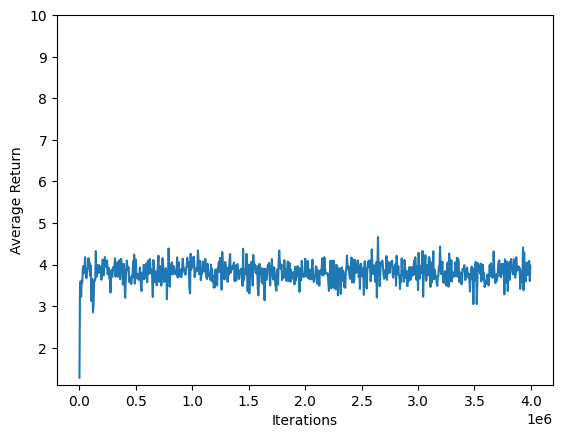

In [9]:
iterations = range(0, train_step_counter + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top = 10)